# 04 - Train Baseline Model

In [15]:
# imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

#notebook settings
pd.set_option('display.max_columns', None)

from scipy.stats import uniform, randint

# building a pipeline to preprocess the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier


In [2]:
data = pd.read_csv(os.path.join('..','data','processed','data_for_model.csv'))

print(data.shape)

data.head()

(7320, 47)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,man city,west brom,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,middlesbrough,liverpool,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


## Standardizing and Encoding

In [3]:
# defining the target variable
y = data['full_time_result']
X = data.drop('full_time_result', axis=1)

# numerical features
numerical_features = X.select_dtypes(exclude='object').columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# categorical features
categorical_features = X.select_dtypes(include='object').columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['day_of_week', 'month', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'home_roll_3_avg_home_corners',
       'away_roll_3_avg_home_corners', 'home_roll_3_avg_away_corners',
       'away_roll_3_avg_away_corners', 'home_roll_3_avg_home_yellow_cards',
       'away_roll_3_avg...
       'away_roll_5_avg_away_red_cards', 'home_roll_5_avg_ratio_h_a_shots',
       'away_roll_5_avg_ratio_h_a_shots', 'home_roll_5_avg_ratio_a_h_shots',
       'away_roll_5_avg_ratio_a_h_shots', 'home_cumulative_points',
       'away_cumulative_points'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['home_team', 'away_team'], dtype='object'))])

## Splinting the data into training and testing sets

In [4]:
# split the data into training and testing sets 80% training, 20% testing

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5856, 46), (1464, 46), (5856,), (1464,))

## Selecting optimal best features with RFECV

In [5]:
%%time

# Set up RFECV with RandomForest as the feature selector
rfecv = RFECV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
              step=1, 
              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
              scoring='accuracy',
              n_jobs=-1)

# Create the pipeline for preprocessing and feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv)  # Use RFECV here for feature selection only
])

# Fit the pipeline on the training data to perform feature selection
print("Starting RFECV feature selection with RandomForest...")
pipeline.fit(X_train, y_train)
print("Feature selection complete.")

# Transform the training and test sets to keep only selected features
X_train_selected = pipeline.transform(X_train)
X_test_selected = pipeline.transform(X_test)

# Access selected features information
selected_features = rfecv.support_  # Boolean mask of selected features
feature_ranking = rfecv.ranking_    # Ranking of features (1 means selected)

# Print selected features information
print(f"\nRFECV selected {selected_features.sum()} features out of {len(selected_features)} total features.")
print("Feature rankings (1 indicates selected features):")
print(feature_ranking)

# Optional: Print selected feature names if available
try:
    # Get feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out()  # Feature names after transformation
    
    # Get names of selected features
    selected_feature_names = [feature_names[i] for i in range(len(selected_features)) if selected_features[i]]
    
    print("\nSelected Feature Names after RFECV:")
    print(selected_feature_names)
except AttributeError:
    print("\nFeature names could not be extracted. Ensure the preprocessor is a ColumnTransformer with feature names available.")

Starting RFECV feature selection with RandomForest...
Feature selection complete.

RFECV selected 11 features out of 132 total features.
Feature rankings (1 indicates selected features):
[ 22  16  26  25  24  23   6   5   8   7  17  15  13  14  39  36  29  31
   1   1   1   1   1   1   1   1   9  10  12  11  21  20  18  19  32  30
  27  28   1   4   3   2   1   1  49  53  93  77 114  90  78  99  62  72
 109 113  45  71 120  51  57 112  89 117 100  69  54 118  41  40  81  42
  85  98  94  92 101 108  59  65  61  83  38  74  58  48  73  70  34  50
  97  76 116  88  79 102  82  80 115 111  33  60 122  35  55 110  91 121
 107  75  47 119  43  37  86  56  95 103  96 105 104 106  64  68  63  84
  46  87  52  44  66  67]

Selected Feature Names after RFECV:
['num__home_roll_3_avg_ratio_h_a_shots', 'num__away_roll_3_avg_ratio_h_a_shots', 'num__home_roll_3_avg_ratio_h_a_fouls', 'num__away_roll_3_avg_ratio_h_a_fouls', 'num__home_roll_3_avg_ratio_a_h_shots', 'num__away_roll_3_avg_ratio_a_h_shots'

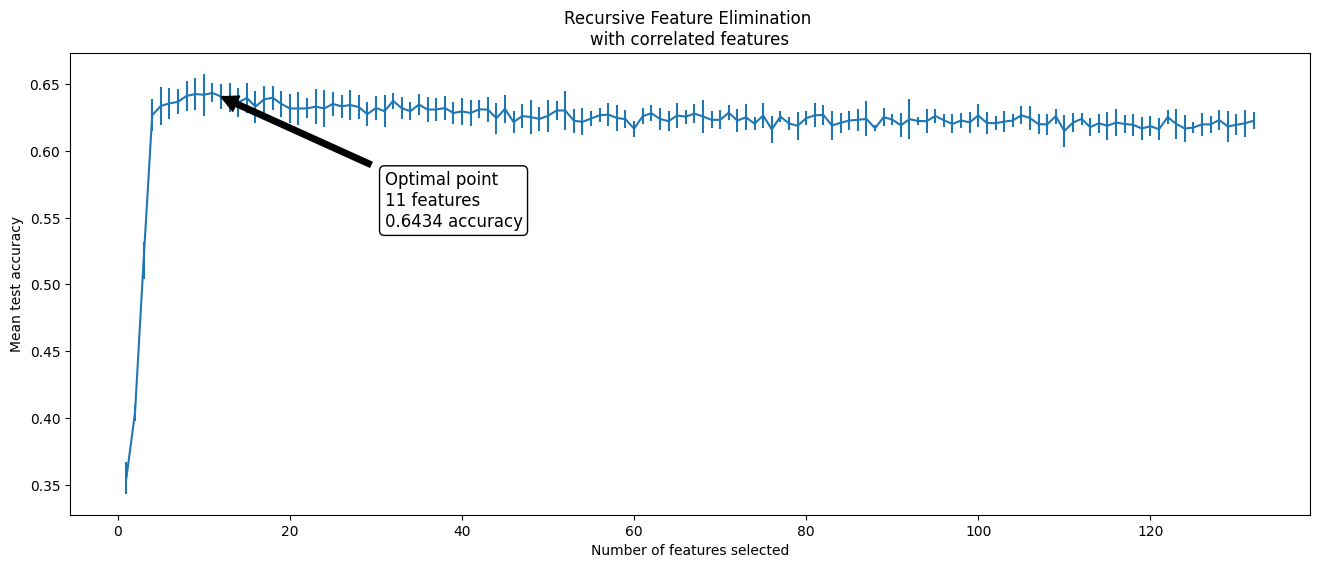

In [6]:
cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure(figsize=(16, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")

# Annotate the optimal point
optimal_idx = rfecv.n_features_ - 1
optimal_n_features = cv_results["n_features"][optimal_idx]
optimal_score = cv_results["mean_test_score"][optimal_idx]
plt.annotate(
    f'Optimal point\n{optimal_n_features} features\n{optimal_score:.4f} accuracy',
    xy=(optimal_n_features, optimal_score),
    xytext=(optimal_n_features + 20, optimal_score - 0.1),
    arrowprops=dict(facecolor='black', shrink=0.05),
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

plt.show()

## Testing baseline models

In [7]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Dictionary to save all metrics
all_metrics = {}

# Define the models you want to test
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
}

# Loop through each model to evaluate on the reduced feature set
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} on selected features...")

    # Cross-validate the model on the selected features and calculate accuracy
    cv_scores = cross_val_score(model, 
                                X_train_selected, 
                                y_train_encoded, 
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                scoring='accuracy', 
                                n_jobs=-1)
    
    # Fit the model on the full training set with selected features and make predictions
    model.fit(X_train_selected, y_train_encoded)
    y_pred_encoded = model.predict(X_test_selected)
    
    # Decode predictions back to original labels
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Generate a classification report and parse it into a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store the results in the dictionary
    all_metrics[model_name] = {
        'cv_mean_accuracy': np.mean(cv_scores),
        'cv_std_accuracy': np.std(cv_scores),
        'classification_report': report
    }

    # Print the metrics
    print(f"Cross-validated accuracy for {model_name}: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

# all_metrics now contains all model performance metrics
print("\nAll Metrics Summary:")
for model, metrics in all_metrics.items():
    print(f"\nModel: {model}")
    print(f"Cross-Validated Accuracy: {metrics['cv_mean_accuracy']:.4f} (+/- {metrics['cv_std_accuracy']:.4f})")
    print("Classification Report:")
    for label, values in metrics['classification_report'].items():
        print(f"{label}: {values}")


Evaluating RandomForest on selected features...
Cross-validated accuracy for RandomForest: 0.6422 (+/- 0.0083)

Classification Report for RandomForest:
              precision    recall  f1-score   support

           A       0.64      0.68      0.66       437
           D       0.53      0.21      0.30       354
           H       0.66      0.85      0.74       673

    accuracy                           0.64      1464
   macro avg       0.61      0.58      0.57      1464
weighted avg       0.62      0.64      0.61      1464


Evaluating XGBoost on selected features...
Cross-validated accuracy for XGBoost: 0.6300 (+/- 0.0140)

Classification Report for XGBoost:
              precision    recall  f1-score   support

           A       0.63      0.65      0.64       437
           D       0.43      0.25      0.31       354
           H       0.67      0.82      0.74       673

    accuracy                           0.63      1464
   macro avg       0.58      0.57      0.56      1464
we

In [8]:
scores = pd.DataFrame(all_metrics)
scores

,RandomForest,XGBoost
cv_mean_accuracy,0.642248,0.629952
cv_std_accuracy,0.008308,0.014017
classification_report,"{'A': {'precision': 0.6373390557939914, 'recal...","{'A': {'precision': 0.6331096196868009, 'recal..."


### Validating curves of baseline models

In [ ]:
# Define the models you want to test
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
}

def plot_learning_curves_and_return_results(models, X_train_selected, y_train_encoded):
    """
    This function evaluates multiple models by generating learning curves 
    and validation curves for hyperparameter tuning, and returns the results as a pandas DataFrame.
    
    Args:
    - models (dict): A dictionary containing the model name as the key and the model object as the value.
    - X_train_selected (array-like): Training data with selected features.
    - y_train_encoded (array-like): Encoded target labels for training.

    Returns:
    - df_results (DataFrame): A DataFrame containing the results of the learning curves and validation curves.
    """
    # Initialize an empty list to store the results for later
    results = []

    # Loop through each model to evaluate on the reduced feature set
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name} on selected features...")

        # Calculate learning curve
        train_sizes, train_scores, test_scores = learning_curve(model, 
                                                                X_train_selected, 
                                                                y_train_encoded, 
                                                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                                                scoring='accuracy', 
                                                                n_jobs=-1, 
                                                                train_sizes=np.linspace(0.1, 1.0, 10))

        # Store learning curve results in DataFrame
        for i, size in enumerate(train_sizes):
            results.append({
                'Model': model_name,
                'Curve Type': 'Learning Curve',
                'Training Size': size,
                'Train Accuracy': train_scores[i].mean(),
                'Test Accuracy': test_scores[i].mean(),
                'Parameter': None,  # No parameter for learning curve
            })

        # Check if the model has 'n_estimators' parameter (for RandomForest and XGBoost)
        if model_name in ['RandomForest', 'XGBoost']:
            # Calculate validation curve for n_estimators
            param_range = np.arange(1, 30, 2)
            param_train_scores, param_test_scores = validation_curve(model, 
                                                                    X_train_selected, 
                                                                    y_train_encoded, 
                                                                    param_name='n_estimators', 
                                                                    param_range=param_range, 
                                                                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                                                                    scoring='accuracy', 
                                                                    n_jobs=-1)

            # Store validation curve results in DataFrame
            for i, param in enumerate(param_range):
                results.append({
                    'Model': model_name,
                    'Curve Type': 'Validation Curve',
                    'Training Size': None,  # No training size for validation curve
                    'Train Accuracy': param_train_scores[i].mean(),
                    'Test Accuracy': param_test_scores[i].mean(),
                    'Parameter': param,  # Store the parameter value
                })

        # Plot learning curve
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
        plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Accuracy')
        plt.xlabel('Training examples')
        plt.ylabel('Accuracy')
        plt.title(f'{model_name} Learning Curve')
        plt.legend()

        # Plot validation curve
        if model_name in ['RandomForest', 'XGBoost']:
            plt.subplot(1, 2, 2)
            plt.plot(param_range, param_train_scores.mean(axis=1), label='Training Accuracy')
            plt.plot(param_range, param_test_scores.mean(axis=1), label='Validation Accuracy')
            plt.xlabel('n_estimators')
            plt.ylabel('Accuracy')
            plt.title(f'{model_name} Validation Curve')
            plt.legend()

        plt.tight_layout()
        plt.show()

    # Convert the results list to a pandas DataFrame
    df_results = pd.DataFrame(results)
    return df_results


Evaluating RandomForest on selected features...


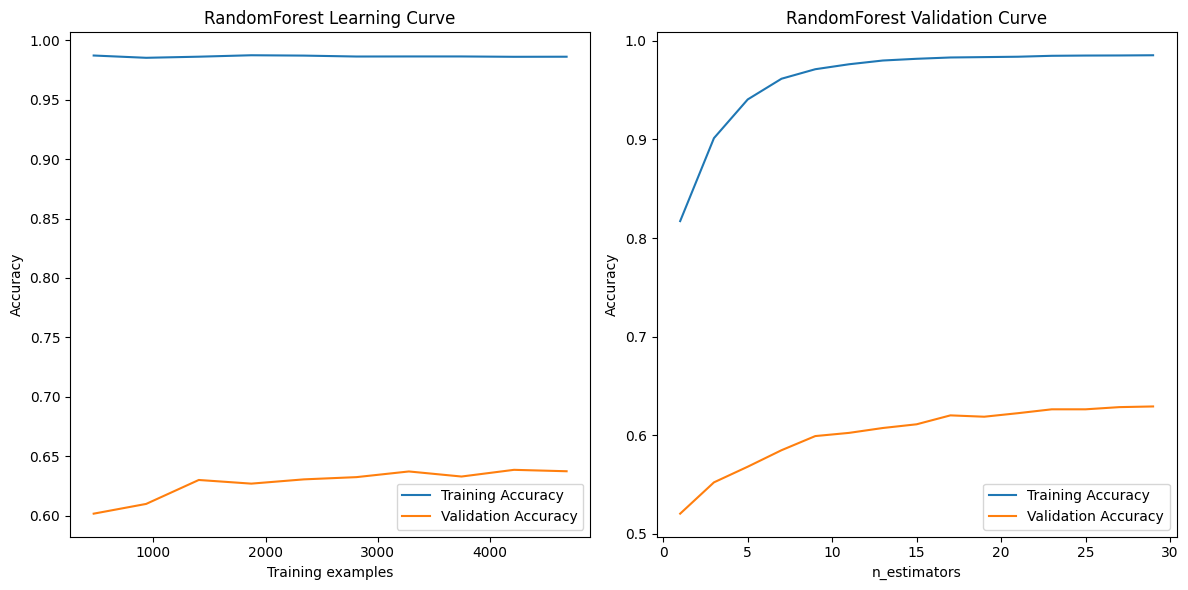


Evaluating XGBoost on selected features...


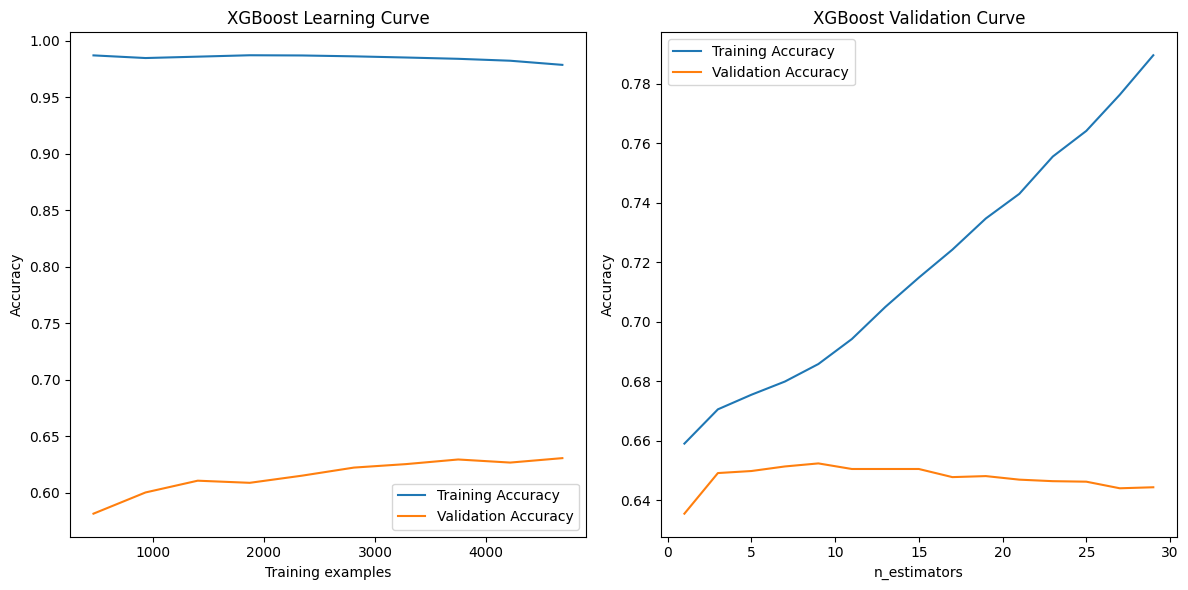

In [13]:
df_results = plot_learning_curves_and_return_results(models, X_train_selected, y_train_encoded)

Solutions to Reduce Overfitting:
- Cross-Validation:
  - You're already using 5-fold cross-validation (cv=5), which is great for reducing variance. However, you may want to increase the number of folds (e.g., to 10) or use StratifiedKFold for classification problems to ensure a better split of classes.

- Regularization:
  - For Random Forest:
    - max_depth: Limit the depth of the trees to avoid overly deep trees that fit the noise in the data.
    - min_samples_split: Increase the minimum number of samples required to split a node.
    - min_samples_leaf: Increase the minimum number of samples required at each leaf node.
  - For XGBoost:
    - max_depth: Limit the maximum depth of trees to prevent overly complex trees.
    - learning_rate: Reduce the learning rate and increase the number of iterations (n_estimators) to prevent overfitting. A smaller learning rate can make the model more robust, but requires more trees.
    - subsample: Use a subset of the data for training each tree (e.g., subsample=0.8), which introduces randomness and prevents overfitting.
    - colsample_bytree: Randomly select features for each tree, which can help reduce overfitting.

In [14]:
# Display the first few rows of the DataFrame
print("\nResults DataFrame:")
df_results.head()


Results DataFrame:


,Model,Curve Type,Training Size,Train Accuracy,Test Accuracy,Parameter
0,RandomForest,Learning Curve,468.0,0.987179,0.601603,NaN
1,RandomForest,Learning Curve,936.0,0.985256,0.609801,NaN
2,RandomForest,Learning Curve,1405.0,0.986192,0.629952,NaN
3,RandomForest,Learning Curve,1873.0,0.987400,0.626877,NaN
4,RandomForest,Learning Curve,2342.0,0.987105,0.630464,NaN


## Hypterparameter tuning to reduce overfitting

In [16]:
# Define a dictionary with both models
models = {
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'param_dist': {
            'n_estimators': randint(100, 300),  # Fewer estimators, good range for efficiency
            'max_depth': randint(3, 10),  # Depth between 3 and 10 is typical for XGBoost
            'learning_rate': uniform(0.05, 0.15),  # Learning rate between 0.05 and 0.2 for efficiency
            'subsample': uniform(0.7, 0.3),  # Larger sample size for better generalization
            'colsample_bytree': uniform(0.7, 0.3),  # Same for column sample
            'gamma': uniform(0, 0.2),  # Keeping a small range for regularization
            'lambda': uniform(0, 1),  # L2 regularization (no big changes)
            'alpha': uniform(0, 1),  # L1 regularization (no big changes)
        },
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'param_dist': {
            'n_estimators': randint(100, 300),  # Fewer estimators, good range for efficiency
            'max_depth': [None, 10, 20, 30],  # Use None and small values for manageable depth
            'min_samples_split': randint(2, 10),  # Common range for minimum samples split
            'min_samples_leaf': randint(1, 4),  # Common range for leaf size
            'max_features': ['sqrt', 'log2', None],  # Fixed values for max_features
            'bootstrap': [True, False],  # Bootstrap setting to allow both options
        },
    }
}

# Dictionary to store results for both models
results = {}

# Loop through each model and perform RandomizedSearchCV
for model_name, model_info in models.items():
    print(f"\nEvaluating {model_name}...")

    # Get model and parameter distribution
    model = model_info['model']
    param_dist = model_info['param_dist']
    
    # Set up RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=param_dist,
                                       n_iter=50,
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                       n_jobs=-1,
                                       random_state=42,
                                       scoring='accuracy')

    # Perform the RandomizedSearchCV for hyperparameter optimization
    random_search.fit(X_train_selected, y_train_encoded)
    
    # Store the best model and its performance
    results[model_name] = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
    }

    # Print the best parameters and score for the model
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Best cross-validated accuracy for {model_name}: {random_search.best_score_:.4f}")

# You can now access the results for both models
print("\nModel Tuning Results:")
for model_name, result in results.items():
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Cross-Validated Accuracy: {result['best_score']:.4f}")


Evaluating XGBoost...
Best parameters for XGBoost: {'alpha': np.float64(0.6947849330397046), 'colsample_bytree': np.float64(0.9641403517045772), 'gamma': np.float64(0.12487080962675866), 'lambda': np.float64(0.295633685837714), 'learning_rate': np.float64(0.06582413897454059), 'max_depth': 6, 'n_estimators': 127, 'subsample': np.float64(0.76553213116505)}
Best cross-validated accuracy for XGBoost: 0.6511

Evaluating RandomForest...
Best parameters for RandomForest: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 212}
Best cross-validated accuracy for RandomForest: 0.6475

Model Tuning Results:

Model: XGBoost
Best Parameters: {'alpha': np.float64(0.6947849330397046), 'colsample_bytree': np.float64(0.9641403517045772), 'gamma': np.float64(0.12487080962675866), 'lambda': np.float64(0.295633685837714), 'learning_rate': np.float64(0.06582413897454059), 'max_depth': 6, 'n_estimators': 127, 'subsample': np.float64

### Learning curves of the tuned models


Evaluating RandomForest on selected features...


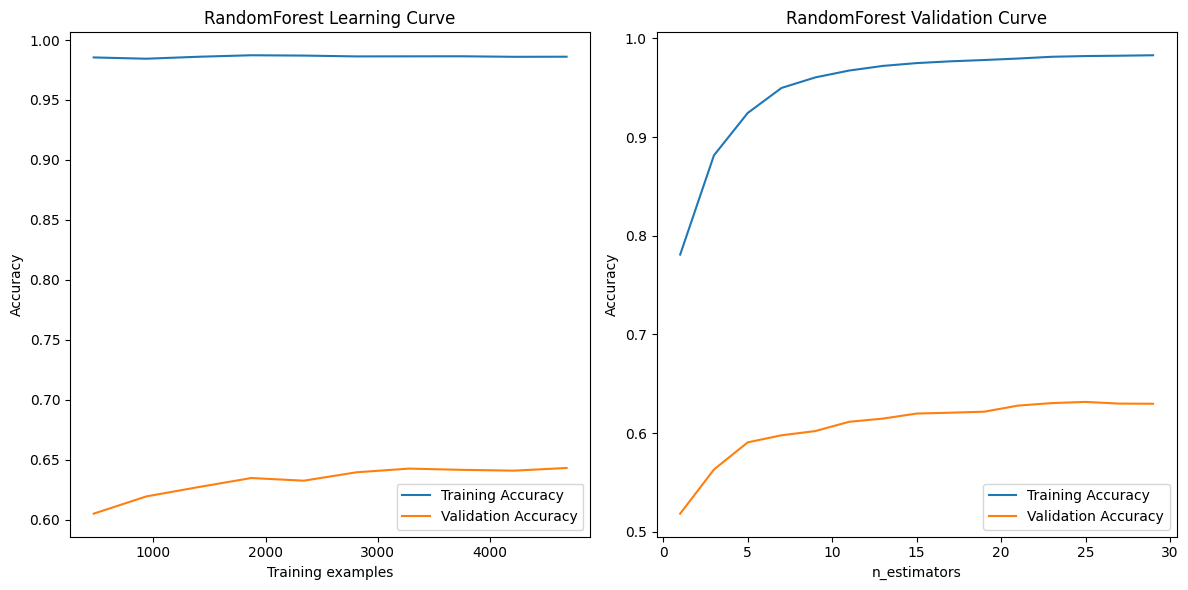


Evaluating XGBoost on selected features...


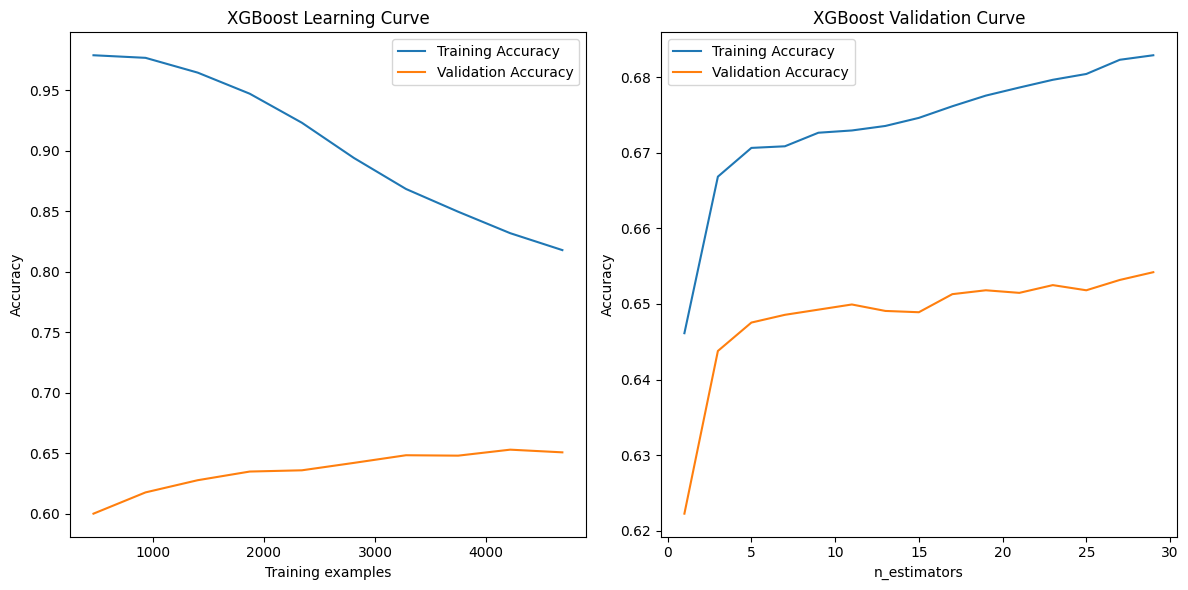

,Model,Curve Type,Training Size,Train Accuracy,Test Accuracy,Parameter
0,RandomForest,Learning Curve,468.0,0.985470,0.605019,NaN
1,RandomForest,Learning Curve,936.0,0.984402,0.619362,NaN
2,RandomForest,Learning Curve,1405.0,0.986050,0.627218,NaN
3,RandomForest,Learning Curve,1873.0,0.987293,0.634732,NaN
4,RandomForest,Learning Curve,2342.0,0.987020,0.632513,NaN
5,RandomForest,Learning Curve,2810.0,0.986335,0.639514,NaN
6,RandomForest,Learning Curve,3278.0,0.986394,0.642588,NaN
7,RandomForest,Learning Curve,3747.0,0.986442,0.641564,NaN
8,RandomForest,Learning Curve,4215.0,0.986002,0.640880,NaN
9,RandomForest,Learning Curve,4684.0,0.986080,0.643100,NaN


In [17]:
# Define the models you want to test
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced', **results['RandomForest']['best_params']),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss', **results['XGBoost']['best_params']),
}

# plot the learning curves and validation curves for the tuned models
plot_learning_curves_and_return_results(models, X_train_selected, y_train_encoded)

## Selection of best model - XGBoost

In [18]:
# use the best model to make predictions
best_model = models['XGBoost']

best_model

XGBClassifier(alpha=np.float64(0.6947849330397046), base_score=None,
              booster=None, callbacks=None, colsample_bylevel=None,
              colsample_bynode=None,
              colsample_bytree=np.float64(0.9641403517045772), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=np.float64(0.12487080962675866), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=np.float64(0.295633685837714),
              learning_rate=np.float64(0.06582413897454059), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=None, ...)

## Creating Pipeline for best model

In [19]:
# Create the pipeline for preprocessing, feature selection, and model fitting
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),           # Step for preprocessing
    ('feature_selection', rfecv),             # Step for feature selection (e.g., RFECV)
    ('model', best_model)                     # Add the best model after feature selection
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['day_of_week', 'month', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'home_roll_3_avg_home_corners',
       'away_roll_3_avg_home_corners', 'home_roll_3_avg_away_corners',
       'away_roll_3_avg_away_corners', 'home_roll_3_avg_hom...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               lambda=np.float64(0.295633685837714),
                               learning_rate=np.float64(0.06582413897454059),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=127, n_jobs=None, ...))])

## Fit model

In [20]:
# Fit the pipeline with the training data
pipeline.fit(X_train, y_train_encoded)

# Evaluate the model on the test set
test_score = pipeline.score(X_test, y_test_encoded)
print(f"Test set accuracy: {test_score:.4f}")

Test set accuracy: 0.6551


In [21]:
pipeline.named_steps['model']

XGBClassifier(alpha=np.float64(0.6947849330397046), base_score=None,
              booster=None, callbacks=None, colsample_bylevel=None,
              colsample_bynode=None,
              colsample_bytree=np.float64(0.9641403517045772), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=np.float64(0.12487080962675866), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              lambda=np.float64(0.295633685837714),
              learning_rate=np.float64(0.06582413897454059), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=None, ...)

## Feature Importance

In [22]:
# After fitting the model, access the classifier within the pipeline
classifier = pipeline.named_steps['model']

# Get feature importances from the classifier
importances = classifier.feature_importances_

# Access all feature names from the preprocessor
try:
    # Get feature names after preprocessing
    all_feature_names = preprocessor.get_feature_names_out()

    # Ensure the length of selected features aligns with preprocessed features
    if len(selected_features) != len(all_feature_names):
        # Align lengths by using only the first part of the names if a mismatch exists
        all_feature_names = all_feature_names[:len(selected_features)]

    # Filter only the selected feature names based on the RFECV selection mask
    selected_feature_names = [all_feature_names[i] for i, is_selected in enumerate(selected_features) if is_selected]
    
    # Combine selected feature names with their importances into a DataFrame
    importance_df = pd.DataFrame({
        'Feature': selected_feature_names,
        'Importance': importances
    })

    # Sort by importance (from highest to lowest)
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Display the sorted importance DataFrame
    print("\nFeature Importances of Selected Features:")
    display(importance_df)
    
except AttributeError:
    print("\nCould not retrieve feature names. Ensure the preprocessor is a ColumnTransformer with feature names available.")


Feature Importances of Selected Features:


,Feature,Importance
10,num__away_cumulative_points,0.235176
9,num__home_cumulative_points,0.231508
8,num__home_roll_5_avg_ratio_h_a_shots,0.070713
4,num__home_roll_3_avg_ratio_a_h_shots,0.070447
1,num__away_roll_3_avg_ratio_h_a_shots,0.063315
5,num__away_roll_3_avg_ratio_a_h_shots,0.057644
0,num__home_roll_3_avg_ratio_h_a_shots,0.056879
2,num__home_roll_3_avg_ratio_h_a_fouls,0.054583
3,num__away_roll_3_avg_ratio_h_a_fouls,0.053815
7,num__away_roll_3_avg_ratio_a_h_fouls,0.053086


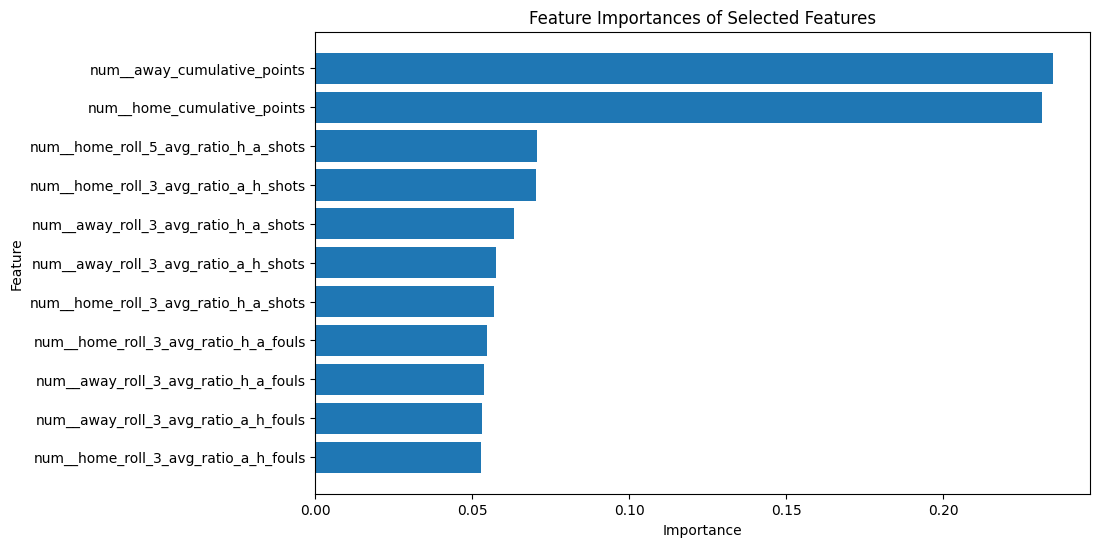

In [23]:
# Plot graph of feature importances for better visualization sorted by importance horizontal bars
plt.figure(figsize=(10, 6))
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=True)
plt.barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Selected Features')
plt.show()

In [24]:
# saving the model
import joblib

# Save the model as a pickle file
filename = os.path.join('..','models','football_model.pkl')
joblib.dump(pipeline, filename)

['../models/football_model.pkl']

In [25]:
# test model with one data point
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a sample data point
data_point = X_test.iloc[[13]]
data_point

,home_team,away_team,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_cumulative_points,away_cumulative_points
1708,everton,burnley,0,12,0.0,1.0,-2.449294e-16,1.0,4.333333,3.666667,4.666667,5.666667,1.666667,2.666667,2.333333,1.333333,0.0,0.0,0.0,0.333333,3.874269,0.801786,0.916667,1.232804,0.70731,1.388889,1.187121,0.968137,4.4,4.4,4.6,4.4,1.4,2.4,2.6,2.0,0.2,0.0,0.4,0.2,2.67969,1.181071,0.89789,1.075641,14,1


In [26]:
# Make a prediction using the loaded model
prediction = loaded_model.predict(data_point)

# Decode the prediction back to the original label
predicted_result = label_encoder.inverse_transform(prediction)

# Display the prediction
print(f"Predicted result: {predicted_result[0]}")

# Display the actual result
print(f"Actual result: {y_test.iloc[0]}")

# Display the prediction probabilities in a dataframe
prediction_probabilities = loaded_model.predict_proba(data_point)

# Convert the prediction probabilities to a DataFrame
prediction_df = pd.DataFrame(prediction_probabilities, columns=label_encoder.classes_)
prediction_df


Predicted result: H
Actual result: H


,A,D,H
0,0.003903,0.119461,0.876636


In [28]:
# Save X_test and y_test as csv files
X_test.to_csv(os.path.join('..','data','processed','X_test.csv'), index=False)
y_test.to_csv(os.path.join('..','data','processed','y_test.csv'), index=False)